# Using Prophet to forecast Olist daily revenue

## 0. Imports

### 0.1. Libraries

In [1]:
# Data Manipulation
import pandas               as pd
import numpy                as np

# Data Visualisation
import seaborn              as sns
import matplotlib           as mpl
import matplotlib.pyplot    as plt
import matplotlib.dates     as mdates

# Prophet
import pystan

from prophet                import Prophet
from prophet.plot           import add_changepoints_to_plot
from prophet.plot           import plot_yearly
from prophet.plot           import plot_cross_validation_metric
from prophet.diagnostics    import cross_validation, performance_metrics

# Other 
import warnings
import logging

from itertools              import product

c:\Users\caiop\anaconda3\envs\time_series_9\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
ERROR:prophet.plot:Importing plotly failed. Interactive plots will not work.


### 0.2. Settings

In [2]:
# Ignoring warnings
warnings.filterwarnings('ignore')

# Pandas Settings
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)

# Visualization Settings
%matplotlib inline

# Set a style
mpl.style.use('ggplot')  # Other options: 'default', 'seaborn', 'bmh', 'dark_background'

# Customize rcParams
mpl.rcParams.update({
    'figure.titlesize': 24,
    'figure.figsize': (18, 6),
    'figure.dpi': 150,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'axes.facecolor': 'white',
    'axes.linewidth': 1,
    'axes.grid': True,
    'xtick.labelsize': 12,
    'xtick.bottom': False,
    'ytick.labelsize': 12,
    'ytick.left': False,
    'legend.fontsize': 12,
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'grid.color': 'lightgray',
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'font.size': 12,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial']
})

# Set a color palette
color_palette = ['#023047', '#e85d04', '#0077b6', '#ff8200', '#0096c7', '#ff9c33']
sns.set_palette(sns.color_palette(color_palette)) 

### 0.3. Functions

In [3]:
def set_plot(fig, title, xlabel, ylabel):
    """
    Summary: This function sets the plot configuration for the initial plots. 
    Args:
        fig: the figure object.
        title: the title of the plot.
        xlabel: the label for the x axis.
        ylabel: the label for the y axis.
    Returns: figure with the image configuration.
    """
    # Customizing
    fig.set_title(title)
    fig.set_xlabel(xlabel, color='black')
    fig.set_ylabel(ylabel, color='black')

    return fig

### 0.4. Dataset

In [49]:
df = pd.read_csv('../data/interim/olist_daily_revenue.csv')

## 1. Data Description

In [39]:
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560 entries, 0 to 559
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           560 non-null    object 
 1   daily_revenue  560 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.9+ KB


,date,daily_revenue
0,2017-02-01,8219.75
1,2017-02-02,8917.64
2,2017-02-03,10183.74
3,2017-02-04,13968.16
4,2017-02-05,8503.79
...,...,...
555,2018-08-10,33424.73
556,2018-08-11,25960.93
557,2018-08-12,31524.21
558,2018-08-13,34271.67


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
daily_revenue,560.00,23395.27,11943.81,3648.10,14667.76,21897.87,30271.13,152653.74


## 2. Preprocessing and Data Exploration

In [50]:
# Setting 'date' as datetime
df['date'] = pd.to_datetime(df['date'])
# Setting 'date' as index
df.set_index('date', inplace=True)
# Setting frequency as daily
df = df.asfreq('D')

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 560 entries, 2017-02-01 to 2018-08-14
Freq: D
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   daily_revenue  560 non-null    float64
dtypes: float64(1)
memory usage: 8.8 KB


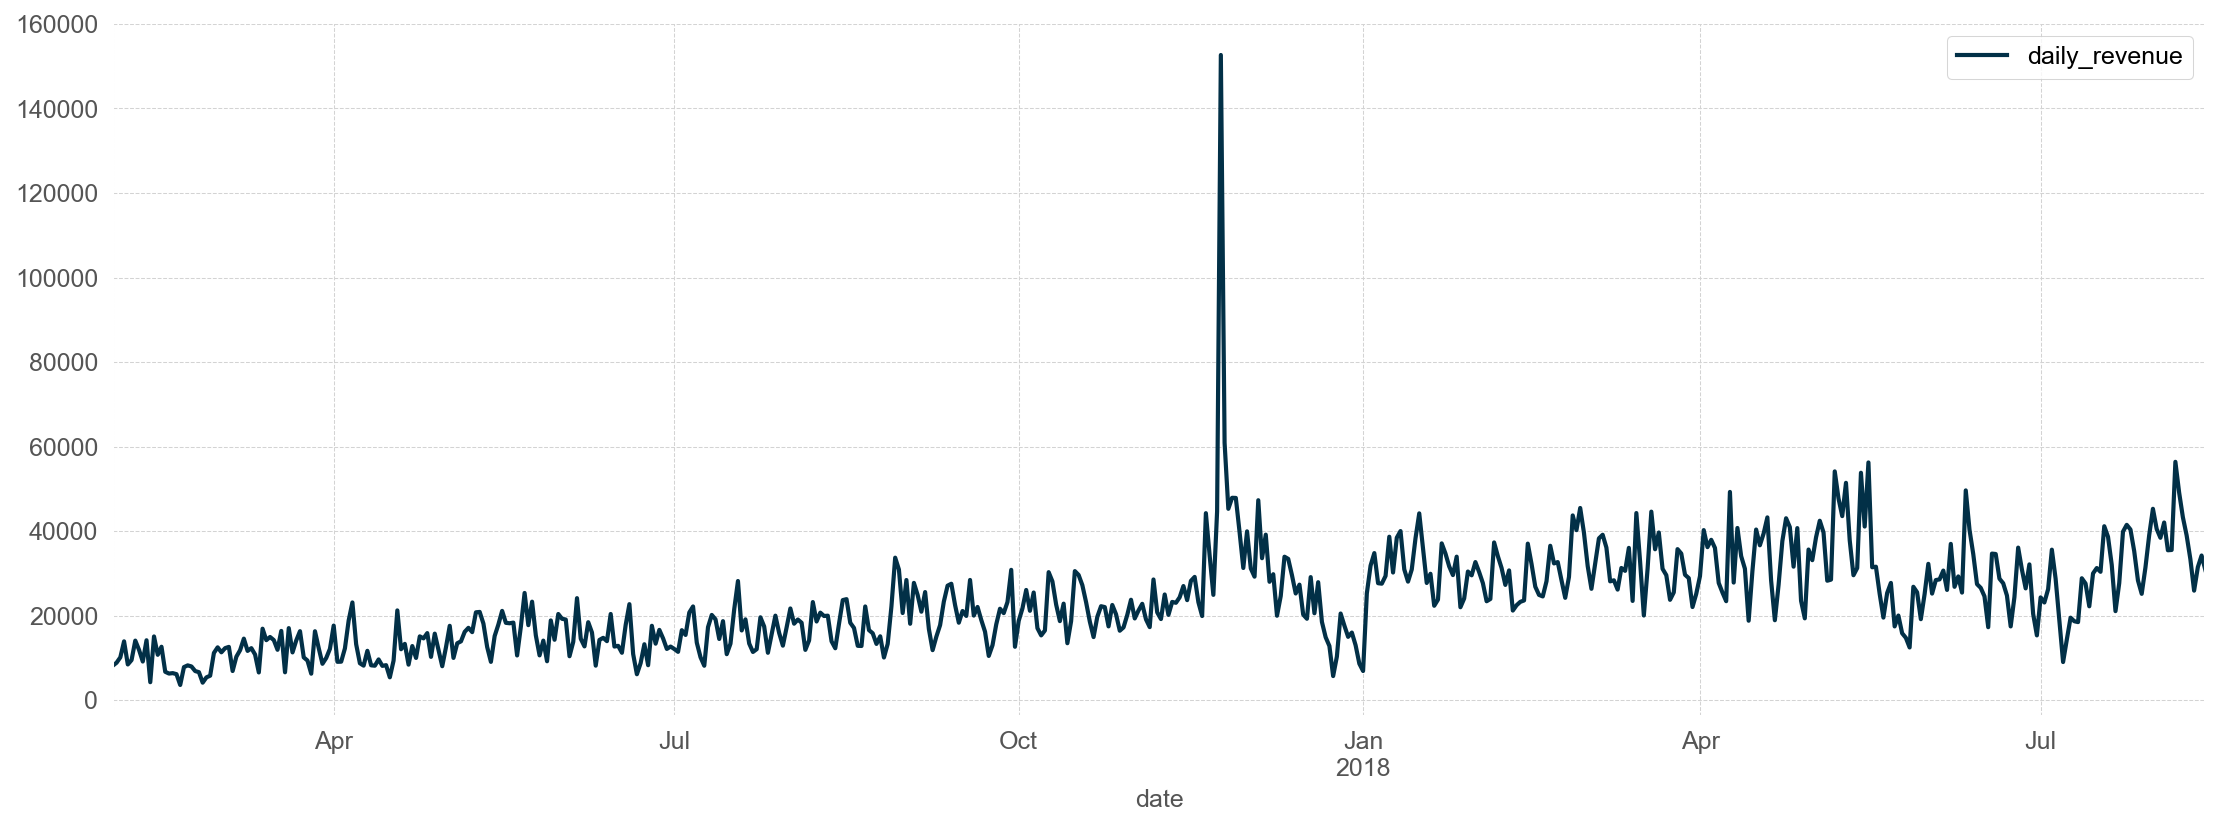

In [9]:
fig = df.plot()

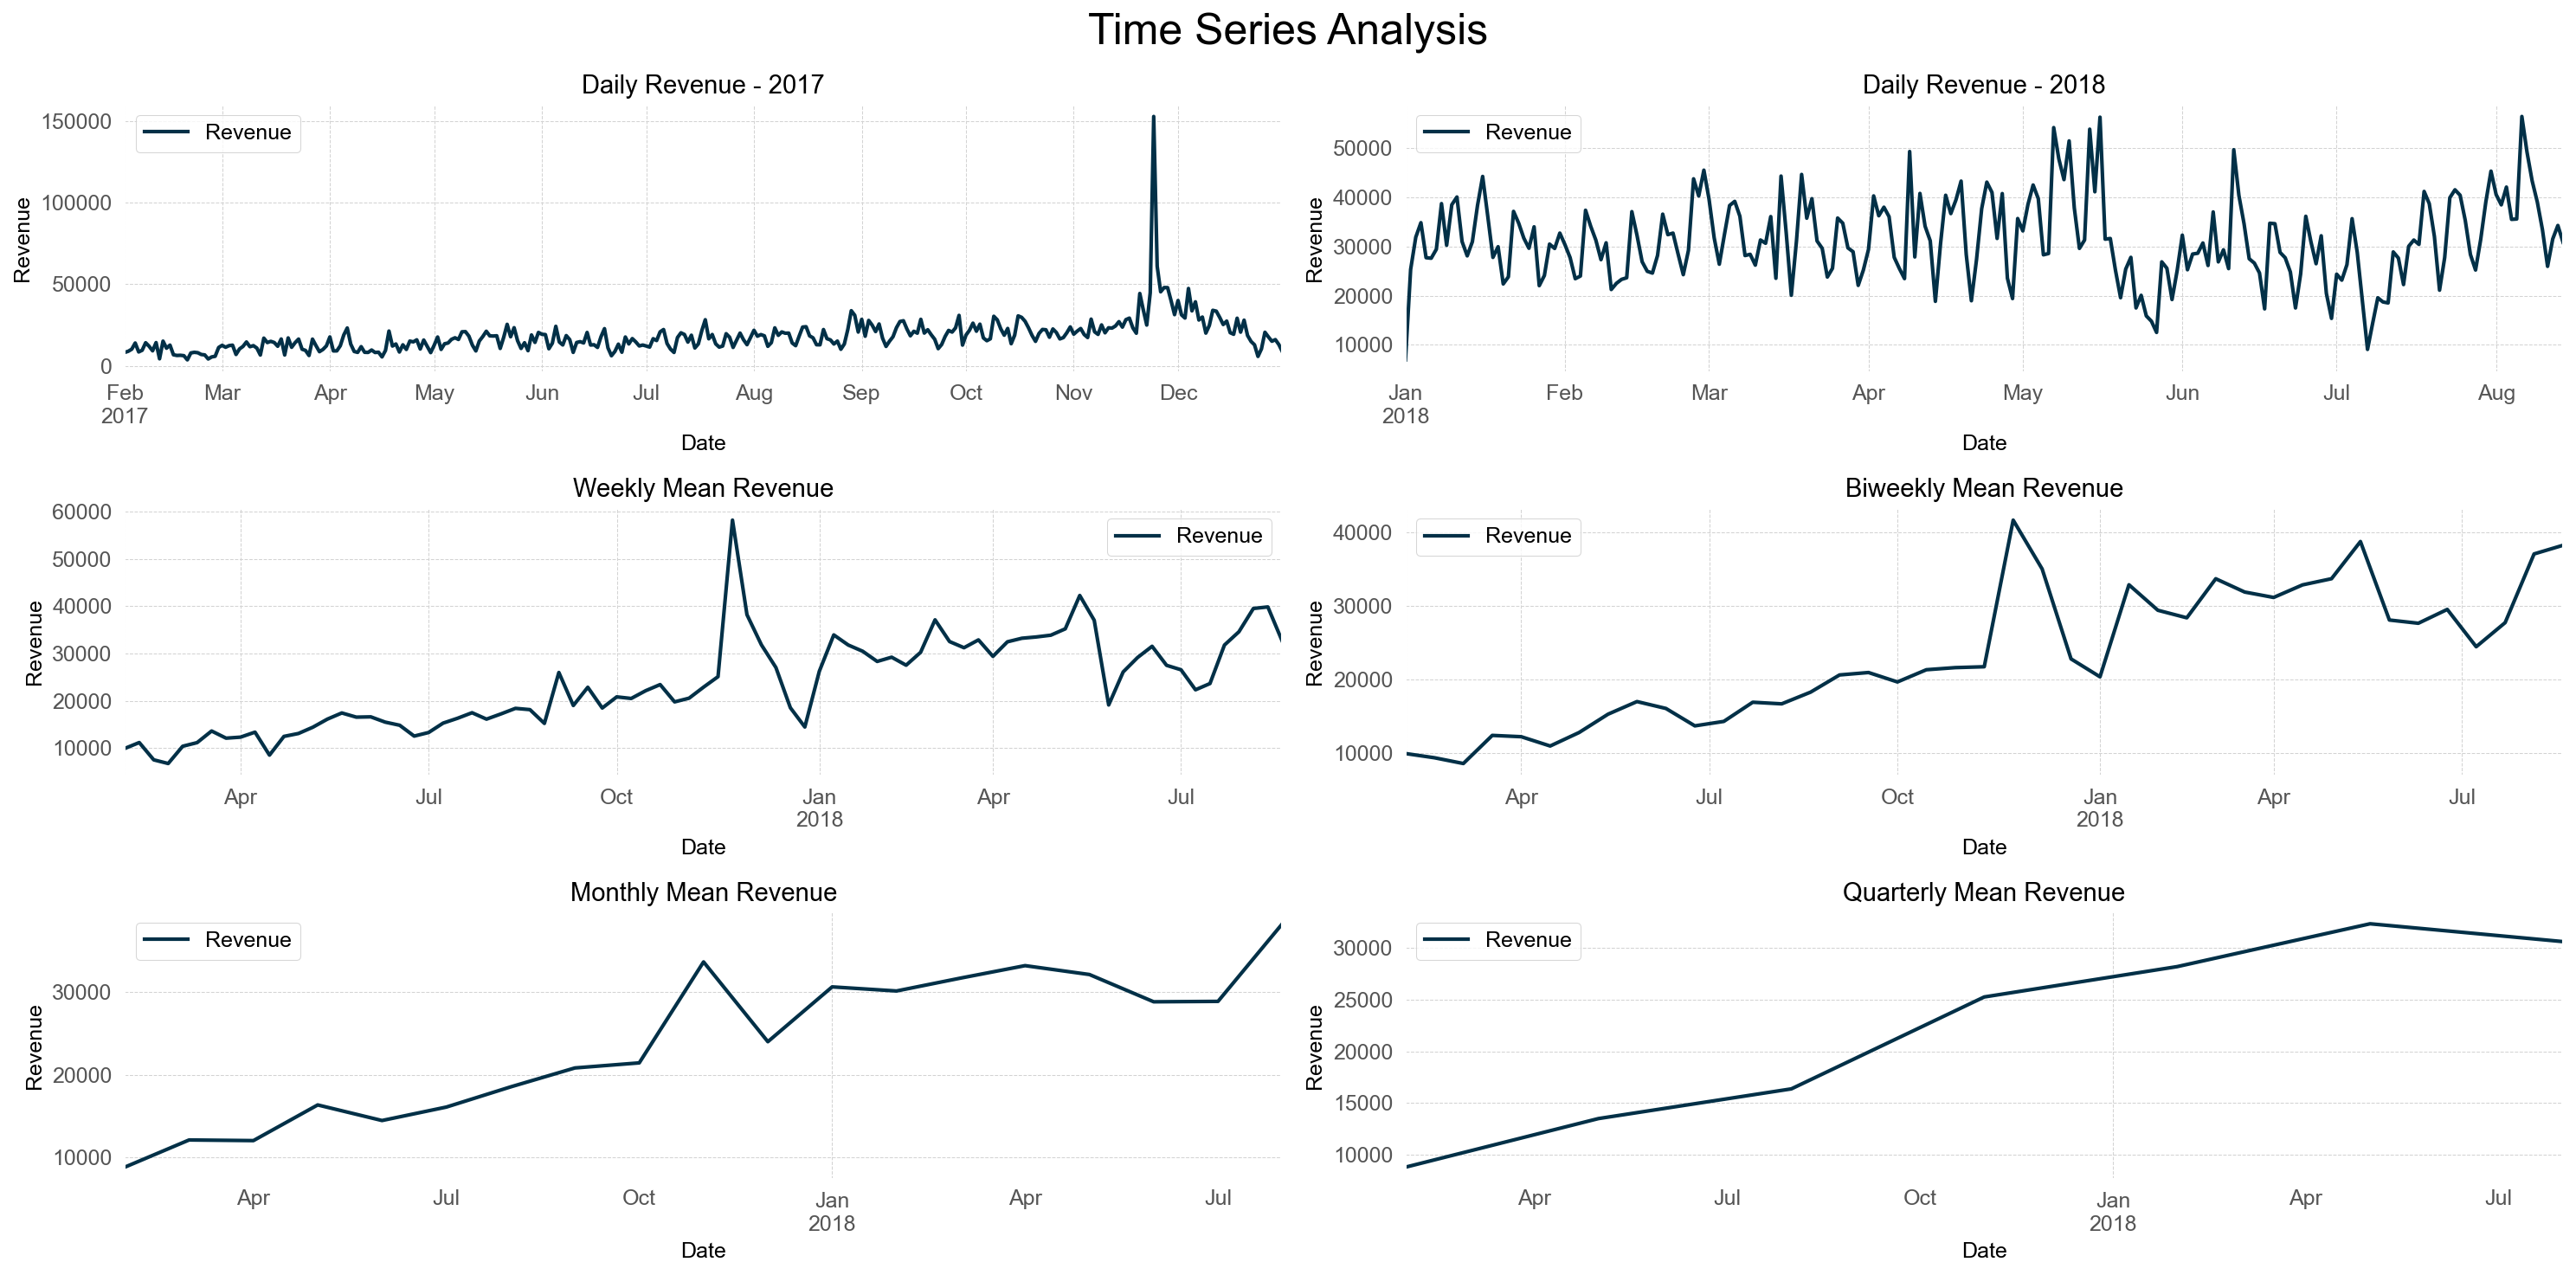

In [22]:
# Creating Figure
fig, axes = plt.subplots(3, 2, figsize=(20, 10))
axes = axes.flatten()

# Plot 1
ax1 = axes[0]
df[df.index.year == 2017].plot(ax=ax1)
ax1.legend(['Revenue'])
set_plot(ax1, 'Daily Revenue - 2017', 'Date', 'Revenue')

# Plot 2
ax2 = axes[1]
df[df.index.year == 2018].plot(ax=ax2)
ax2.legend(['Revenue'])
set_plot(ax2, 'Daily Revenue - 2018', 'Date', 'Revenue')

# Plot 3
ax3 = axes[2]
df.resample('W').mean().plot(ax=ax3)
ax3.legend(['Revenue'])
set_plot(ax3, 'Weekly Mean Revenue', 'Date', 'Revenue')

# Plot 4
ax4 = axes[3]
df.resample('2W').mean().plot(ax=ax4)
ax4.legend(['Revenue'])
set_plot(ax4, 'Biweekly Mean Revenue', 'Date', 'Revenue')

# Plot 5
ax5 = axes[4]
df.resample('M').mean().plot(ax=ax5)
ax5.legend(['Revenue'])
set_plot(ax5, 'Monthly Mean Revenue', 'Date', 'Revenue')

# Plot 6
ax6 = axes[5]
df.resample('3M').mean().plot(ax=ax6)
ax6.legend(['Revenue'])
set_plot(ax6, 'Quarterly Mean Revenue', 'Date', 'Revenue')

# Main title
plt.suptitle('Time Series Analysis')

# Adjust spacing between subplots
plt.tight_layout()

## 2.2. Holdout

In [51]:
df_train = df['2017-02-01':'2018-07-24']
df_test  = df['2018-07-25':'2018-08-14']

In [44]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
daily_revenue,539.00,22857.17,11761.74,3648.10,14378.14,21113.58,29360.87,152653.74


In [52]:
df_train = df_train.reset_index()

df_train.rename(columns={'date': 'ds', 'daily_revenue': 'y'}, inplace=True)

## 3. Running Prophet

In [54]:
m = Prophet()
m.fit(df_train)

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\caiop\AppData\Local\Temp\tmpm51q8018\c4402mwo.json
DEBUG:cmdstanpy:input tempfile: C:\Users\caiop\AppData\Local\Temp\tmpm51q8018\jml99fmh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\caiop\\anaconda3\\envs\\time_series_9\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=18668', 'data', 'file=C:\\Users\\caiop\\AppData\\Local\\Temp\\tmpm51q8018\\c4402mwo.json', 'init=C:\\Users\\caiop\\AppData\\Local\\Temp\\tmpm51q8018\\jml99fmh.json', 'output', 'file=C:\\Users\\caiop\\AppData\\Local\\Temp\\tmpm51q8018\\prophet_modelcp680fl4\\prophet_model-20240821204711

In [55]:
future = m.make_future_dataframe(periods=21, freq='D')
future.tail()

,ds
555,2018-08-10
556,2018-08-11
557,2018-08-12
558,2018-08-13
559,2018-08-14


In [56]:
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
555,2018-08-10,28348.30,18024.80,39650.71,28299.70,28389.13,436.50,436.50,436.50,436.50,436.50,436.50,0.00,0.00,0.00,28784.79
556,2018-08-11,28322.70,12576.69,33098.13,28267.73,28366.44,-5159.72,-5159.72,-5159.72,-5159.72,-5159.72,-5159.72,0.00,0.00,0.00,23162.98
557,2018-08-12,28297.10,14397.76,34601.20,28235.37,28346.31,-4187.15,-4187.15,-4187.15,-4187.15,-4187.15,-4187.15,0.00,0.00,0.00,24109.95
558,2018-08-13,28271.51,21551.29,42575.26,28201.82,28326.48,3445.70,3445.70,3445.70,3445.70,3445.70,3445.70,0.00,0.00,0.00,31717.21
559,2018-08-14,28245.91,20582.38,41791.87,28172.01,28309.34,2642.83,2642.83,2642.83,2642.83,2642.83,2642.83,0.00,0.00,0.00,30888.74


In [57]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
555,2018-08-10,28784.79,18024.80,39650.71
556,2018-08-11,23162.98,12576.69,33098.13
557,2018-08-12,24109.95,14397.76,34601.20
558,2018-08-13,31717.21,21551.29,42575.26
559,2018-08-14,30888.74,20582.38,41791.87


In [76]:
df_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
df_forecast['ds'] = pd.to_datetime(df_forecast['ds'])
df_forecast = df_forecast[df_forecast['ds'] >= '2018-07-25']

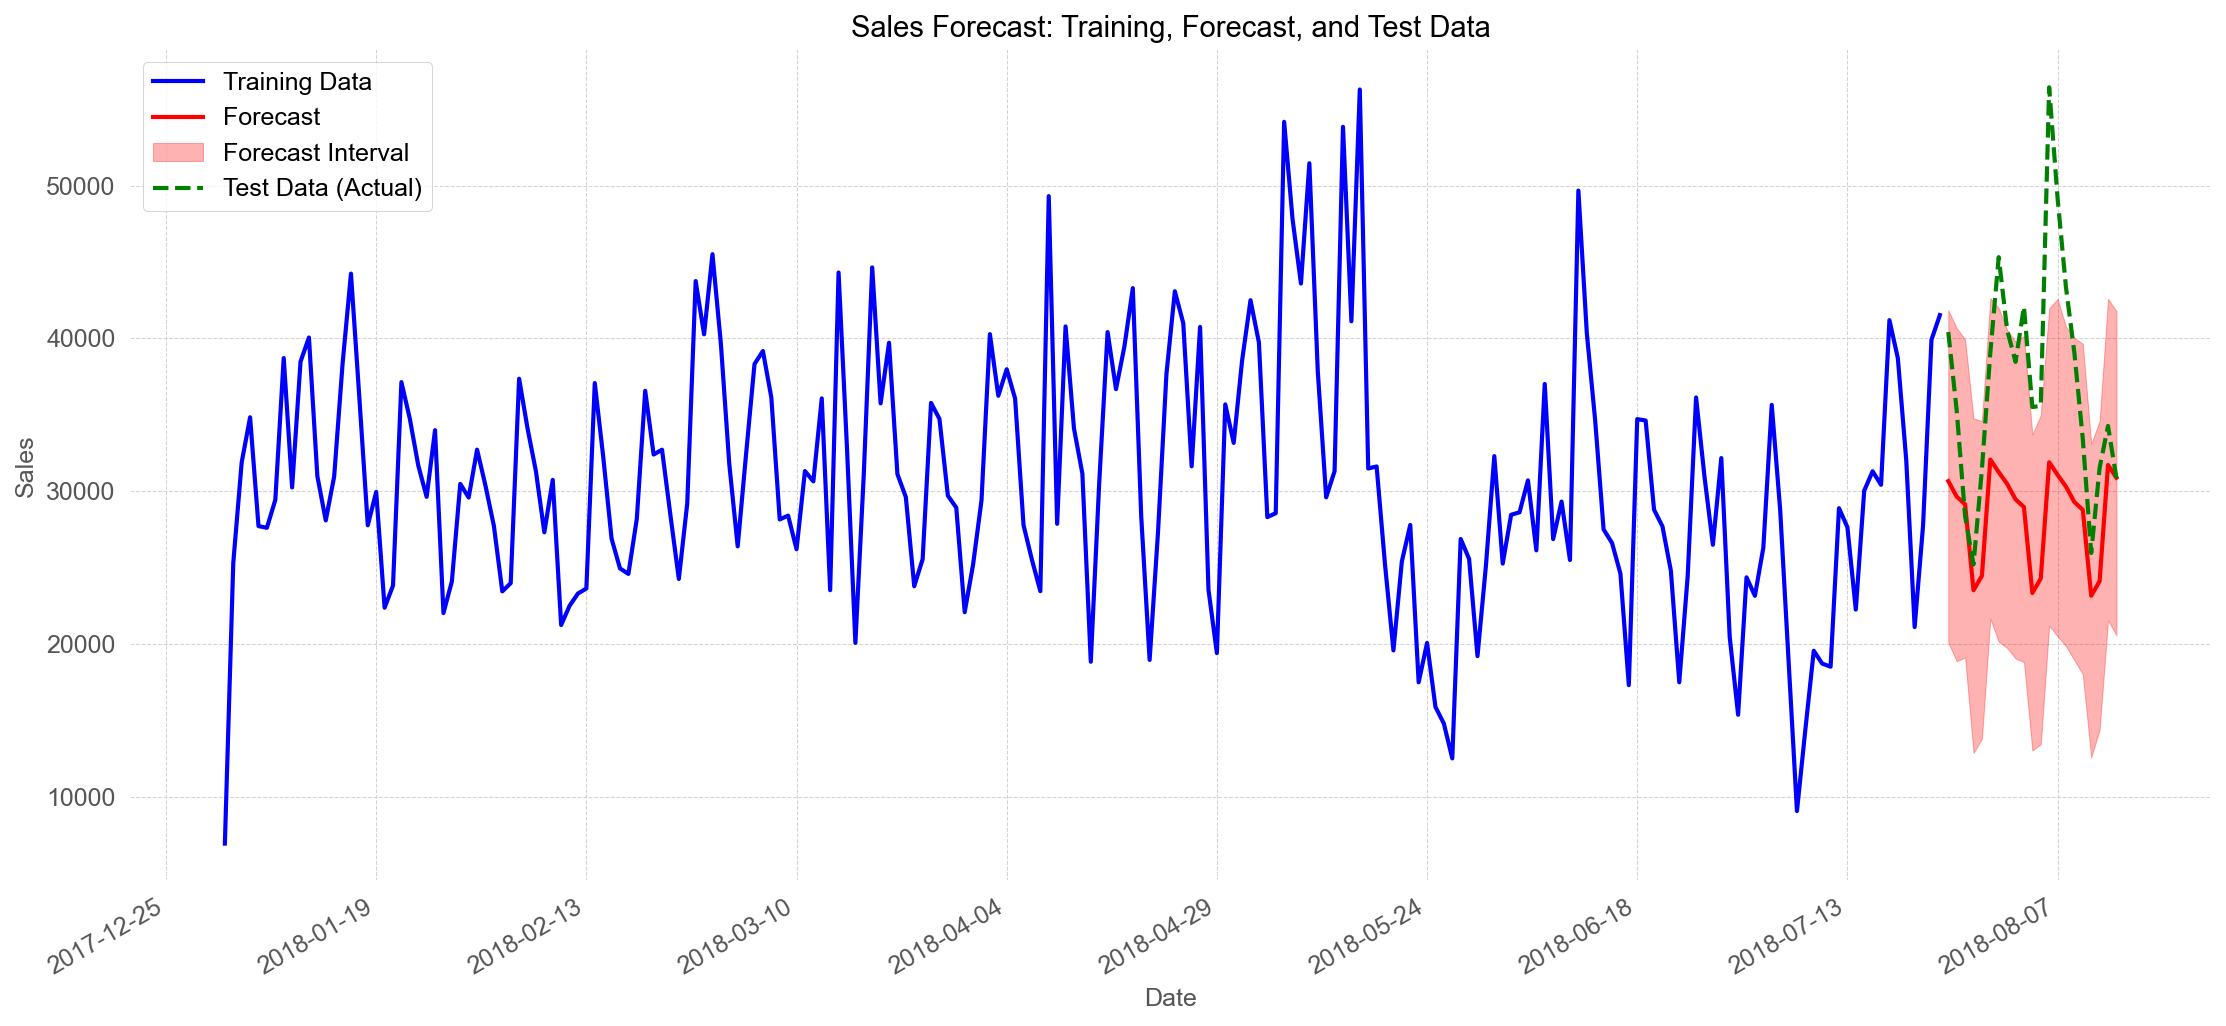

In [84]:
# Ensure 'ds' column is datetime type in all dataframes
df_train['ds'] = pd.to_datetime(df_train['ds'])
df_forecast['ds'] = pd.to_datetime(df_forecast['ds'])
df_test['ds'] = pd.to_datetime(df_test.index)

# Filter df_train
df_train = df_train[df_train['ds'] >= '2018-01-01']

# Create the plot
plt.figure(figsize=(15, 7))

# Plot the training data
plt.plot(df_train['ds'], df_train['y'], label='Training Data', color='blue')

# Plot the forecast
plt.plot(df_forecast['ds'], df_forecast['yhat'], label='Forecast', color='red')
plt.fill_between(df_forecast['ds'], df_forecast['yhat_lower'], df_forecast['yhat_upper'], 
                 alpha=0.3, color='red', label='Forecast Interval')

# Plot the test data
plt.plot(df_test['ds'], df_test['daily_revenue'], '--', label='Test Data (Actual)', color='green')

# Customize the plot
plt.title('Sales Forecast: Training, Forecast, and Test Data')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()

# Adjust x-axis to show more date labels
plt.gcf().autofmt_xdate()  # Rotation
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(12))  # Set maximum number of ticks

# Show the plot
plt.tight_layout()
plt.show()

### Cross Validation

In [95]:
df_cv = df.reset_index()
df_cv = df_cv.rename(columns={'date': 'ds', 'daily_revenue': 'y'})

In [116]:
m = Prophet().fit(df_cv)

df_cv_forecast = cross_validation(m, initial='90 days', horizon='30 days', period='15 days') 

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\caiop\AppData\Local\Temp\tmpm51q8018\rwksb55a.json
DEBUG:cmdstanpy:input tempfile: C:\Users\caiop\AppData\Local\Temp\tmpm51q8018\02jdmdgu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\caiop\\anaconda3\\envs\\time_series_9\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=62796', 'data', 'file=C:\\Users\\caiop\\AppData\\Local\\Temp\\tmpm51q8018\\rwksb55a.json', 'init=C:\\Users\\caiop\\AppData\\Local\\Temp\\tmpm51q8018\\02jdmdgu.json', 'output', 'file=C:\\Users\\caiop\\AppData\\Local\\Temp\\tmpm51q8018\\prophet_modelxf5mkwe_\\prophet_model-20240821214308

In [117]:
df_cv_forecast.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
895,2018-08-10,27533.66,17158.99,38387.51,33424.73,2018-07-15
896,2018-08-11,21974.10,11299.34,32270.53,25960.93,2018-07-15
897,2018-08-12,22838.70,11987.79,32973.99,31524.21,2018-07-15
898,2018-08-13,30379.26,19403.87,40964.63,34271.67,2018-07-15
899,2018-08-14,29511.43,18594.70,40043.17,30858.13,2018-07-15


In [118]:
df_p = performance_metrics(df_cv_forecast)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,30622845.58,5533.79,4298.89,0.20,0.15,0.18,0.84
1,4 days,35294922.05,5940.95,4609.13,0.21,0.17,0.19,0.83
2,5 days,38323919.00,6190.63,4842.75,0.23,0.18,0.20,0.80
3,6 days,47241331.35,6873.23,5189.81,0.26,0.16,0.22,0.74
4,7 days,245758083.51,15676.67,7031.16,0.34,0.18,0.26,0.71
5,8 days,271818427.18,16486.92,7679.82,0.35,0.18,0.27,0.71
6,9 days,277634031.89,16662.35,7819.36,0.35,0.18,0.27,0.72
7,10 days,90834513.45,9530.71,6481.94,0.28,0.17,0.24,0.73
8,11 days,76209136.71,8729.78,6308.70,0.27,0.18,0.24,0.74
9,12 days,68283719.89,8263.40,6109.71,0.27,0.17,0.24,0.74


### 3.1. Grid Search

In [ ]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0]
}

all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

rmses = []

cutoffs = pd.date_range(start='1963-01-01', end='1968-06-01', freq='6MS')

for params in all_params:
    m = Prophet(**params)
    m.add_country_holidays(country_name='US')
    m.fit(df)

    df_cv = cross_validation(model=m, horizon='365 days', cutoffs=cutoffs)
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\caiop\AppData\Local\Temp\tmpbsawl3u1\n_170coa.json
DEBUG:cmdstanpy:input tempfile: C:\Users\caiop\AppData\Local\Temp\tmpbsawl3u1\0s4k1sv5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\caiop\\anaconda3\\envs\\time_series_9\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=40518', 'data', 'file=C:\\Users\\caiop\\AppData\\Local\\Temp\\tmpbsawl3u1\\n_170coa.json', 'init=C:\\Users\\caiop\\AppData\\Local\\Temp\\tmpbsawl3u1\\0s4k1sv5.json', 'output', 'file=C:\\Users\\caiop\\AppData\\Local\\Temp\\tmpbsawl3u1\\prophet_modelw7orcqqa\\prophet_model-20240821195512